# Introduction to Neural Networks with PyTorch

### Typical workflow
Define Dataset, Dataloader -> Define Model -> Train -> Predict

## Dataset and Dataloader

In [25]:
import torch
from torchvision import datasets
import torchvision.transforms as tf
import torch.nn.functional as F

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=tf.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=tf.ToTensor())

#### Dataset stores the samples and their corresponding labels while DataLoader wraps an iterable around the dataset

- Batch size = number of datasamples propogated before parameters are updated

In [26]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [27]:
# Using the dataloader

loader = enumerate(train_dl)
batch, (x,y) = next(loader)
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


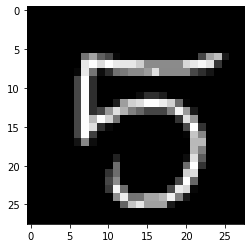

tensor(5)


In [28]:
import matplotlib.pyplot as plt
plt.imshow(x[0][0], cmap='gray')
plt.show()
print(y[0])

### Model (CNN)
- Model does not return probabilities in this case

- Input Channels are the number of channels in the image (RGB = 3, Grayscale = 1, Only applies to first convolution)

- Output Channels are the number of feature maps

- Dropout essentially zeros at random some values, with probability p

In [35]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
                            #  Input Channel, Output Channel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256) # 3*3*64 because we have 64 feature maps by the end of conv3
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1, 3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [36]:
# Looking at models outputs using a random input tensor
def test():
    model = CNN()
    x = torch.randn(1, 1, 28, 28)
    with torch.no_grad():
        y = model(x)
    print(y.shape, y)
    
    # evaluating probabilites
    print(y.argmax(1))
    
test()

torch.Size([1, 10]) tensor([[ 0.0498, -0.0186,  0.0051, -0.3020,  0.1726, -0.1470, -0.0754,  0.1435,
         -0.0216,  0.0281]])
tensor([4])


## Training the model

#### Hyperparameters
- adjustable params that you control optimisation process

- Epochs = number of times to iterate over dataset
- Learning Rate= how much to update the model paramters at each epoch

In [37]:
LR = 1e-3
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
model = CNN()
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = 'cpu'

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device=DEVICE)
        y = y.to(device=DEVICE)
        #compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%200 ==0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=DEVICE)
            y = y.to(device=DEVICE)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [39]:
model = model.to(device=DEVICE)

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n ++++++++++++++++++++++++++++++++++++++++++++++++")
    train_loop(train_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch 1
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 2.303724  [    0/60000]
loss: 0.352928  [12800/60000]
loss: 0.263179  [25600/60000]
loss: 0.159449  [38400/60000]
loss: 0.187971  [51200/60000]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.130147 

Epoch 2
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.097313  [    0/60000]
loss: 0.138947  [12800/60000]
loss: 0.041755  [25600/60000]
loss: 0.017731  [38400/60000]
loss: 0.211607  [51200/60000]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.082851 

Epoch 3
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.061435  [    0/60000]
loss: 0.091965  [12800/60000]
loss: 0.212566  [25600/60000]
loss: 0.086738  [38400/60000]
loss: 0.110910  [51200/60000]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.065476 

Epoch 4
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 0.034661  [    0/60000]
loss: 0.067980  [12800/60000]
loss: 0.051534  [25600/60000]
loss: 0.097425  [38400/60000]
loss: 0.039200  [51200/60000]
Test Error: 

## Predicting classes
- Using our trained model to predict 

In [58]:
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Other Model
omodel = torch.load("./really_good_model.ptcnn", map_location=torch.device('cpu'))
#image = Image.open('./topredict.jpeg').convert("L")
images = {x.split(".")[0]:cv2.bitwise_not(cv2.cvtColor(np.array(Image.open( "./to_predict/" + x)), cv2.COLOR_BGR2GRAY)) for x in os.listdir("./to_predict")}

In [59]:
# https://pytorch.org/vision/stable/transforms.html
transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((28,28))
])

transformed_images = {}

for image in images.keys():
    images[image] = cv2.resize(images[image], (28, 28))
    transformed_images[image] = transform(images[image])

#image_tensor = transform(image)
#image_tensor.shape

Real 	:	 Pred

CORRECT!	 3 	:	 3


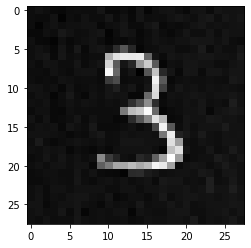

CORRECT!	 6 	:	 6


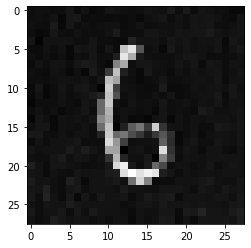

WRONG!  	 2 	:	 0


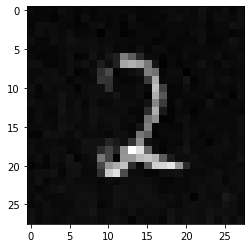

CORRECT!	 4 	:	 4


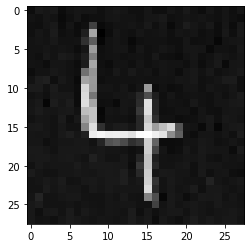

CORRECT!	 0 	:	 0


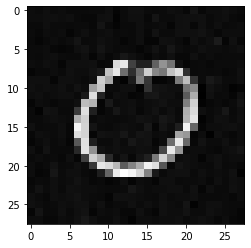

CORRECT!	 8 	:	 8


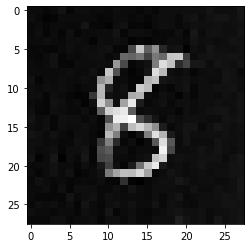

CORRECT!	 5 	:	 5


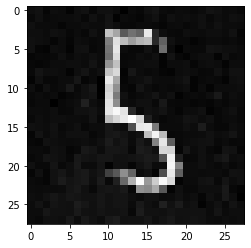

CORRECT!	 1 	:	 1


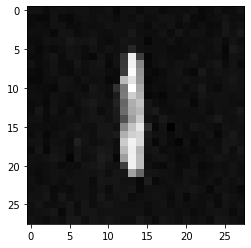

CORRECT!	 7 	:	 7


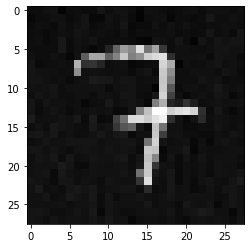

CORRECT!	 9 	:	 9


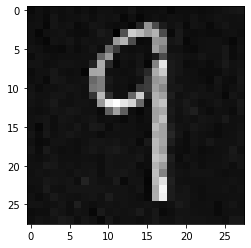

Accuracy: 90.0%


In [60]:
import time
nums = {"ZERO":0, 'ONE':1, 'TWO':2, 'THREE':3, 'FOUR':4, 'FIVE':5, 'SIX':6, 'SEVEN':7, 'EIGHT':8, 'NINE':9}
print("Real", "\t:\t", "Pred" + "\n")
correct = 0
for key, image_tensor in transformed_images.items():
    image_tensor = image_tensor.resize(1, 1, 28, 28)
    image_tensor = image_tensor.to(device=DEVICE)
    pred = omodel(image_tensor)
    if nums[key.upper()] == int(torch.argmax(pred)):
        correct += 1
        print("CORRECT!\t", nums[key.upper()], "\t:\t", int(torch.argmax(pred)))
    else:
        print("WRONG!  \t", nums[key.upper()], "\t:\t", int(torch.argmax(pred)))
    plt.figure()
    plt.imshow(images[key], cmap='gray')
    plt.show()
print("Accuracy: ", correct/10 * 100, "%", sep='')